In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib
from tqdm import tqdm
import cv2
import glob

RAW_DIR = "../data/raw"
PROCESSED_DIR = "../data/processed"
AUGMENTED_DIR = "../data/augmented"
MODEL_DIR = "../models"

os.makedirs(PROCESSED_DIR, exist_ok=True)
os.makedirs(AUGMENTED_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)


In [84]:
ratings_df = pd.read_csv('ratings.dat', sep='::', engine='python', encoding='latin1',
                         names=['user_id', 'item_id', 'rating', 'timestamp'])

movies_df = pd.read_csv('movies.dat', sep='::', engine='python', encoding='latin1',
                        names=['item_id', 'title', 'genres'])

users_df = pd.read_csv('users.dat', sep='::', engine='python', encoding='latin1',
                       names=['user_id', 'gender', 'age', 'occupation', 'zip_code'])


In [85]:
ratings_with_movies = ratings_df.merge(movies_df, on='item_id')

df = ratings_with_movies.merge(users_df, on='user_id')

print(df.head())


   user_id  item_id  rating  timestamp  \
0        1     1193       5  978300760   
1        1      661       3  978302109   
2        1      914       3  978301968   
3        1     3408       4  978300275   
4        1     2355       5  978824291   

                                    title                        genres  \
0  One Flew Over the Cuckoo's Nest (1975)                         Drama   
1        James and the Giant Peach (1996)  Animation|Children's|Musical   
2                     My Fair Lady (1964)               Musical|Romance   
3                  Erin Brockovich (2000)                         Drama   
4                    Bug's Life, A (1998)   Animation|Children's|Comedy   

  gender  age  occupation zip_code  
0      F    1          10    48067  
1      F    1          10    48067  
2      F    1          10    48067  
3      F    1          10    48067  
4      F    1          10    48067  


Item-Based 

In [ ]:
#cсводная таблица пользователь-товар (users x items), используя только item_id
user_item_matrix = df.pivot_table(index="user_id", columns="item_id", values="rating")
user_item_matrix_filled = user_item_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)
user_item_matrix_filled = user_item_matrix_filled - user_item_matrix_filled.mean(axis=1).values[:, None]

# косинусное сходство между фильмами
item_similarity = cosine_similarity(user_item_matrix_filled.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

# Функция для получения рекомендаций на основе item-based подхода
def recommend_items_item_based(user_id, num_recommendations=5):
    user_ratings = user_item_matrix.loc[user_id].dropna()
    scores = pd.Series(0, index=item_similarity_df.columns)
    
    for item, rating in user_ratings.items():
        scores += item_similarity_df[item] * rating
    
    scores = scores.drop(user_ratings.index)
    return scores.nlargest(num_recommendations)

print(recommend_items_item_based(user_id=1))
print(recommend_items_item_based(user_id=22))


item_id
1198    34.193090
318     32.473313
1196    30.029414
953     27.352721
593     27.329076
dtype: float64
item_id
260     33.784352
2028    29.481066
2000    29.375032
50      28.150458
593     27.887669
dtype: float64


In [97]:
user_item_matrix

item_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


User-Based 

In [ ]:
# косинусное сходство между пользователями
user_similarity = cosine_similarity(user_item_matrix_filled)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# Функция для получения рекомендаций на основе user-based подхода
def recommend_items_user_based(user_id, num_recommendations=5):
    similar_users = user_similarity_df[user_id].drop(user_id).nlargest(5)
    weighted_ratings = pd.Series(0, index=user_item_matrix.columns)
    
    for similar_user, similarity in similar_users.items():
        user_ratings = user_item_matrix.loc[similar_user].dropna()
        weighted_ratings.loc[user_ratings.index] += user_ratings * similarity
    
    weighted_ratings = weighted_ratings.drop(user_item_matrix.loc[user_id].dropna().index)
    return weighted_ratings.nlargest(num_recommendations)


print(recommend_items_user_based(user_id=1))
print(recommend_items_user_based(user_id=22))

item_id
364    2.160645
912    2.155867
969    2.155867
858    2.103418
480    2.002464
dtype: float64
item_id
260     5.306935
593     5.083267
2028    5.083267
1617    4.876096
1266    4.873338
dtype: float64


Используем KMeans для кластеризации пользователей по их предпочтениям

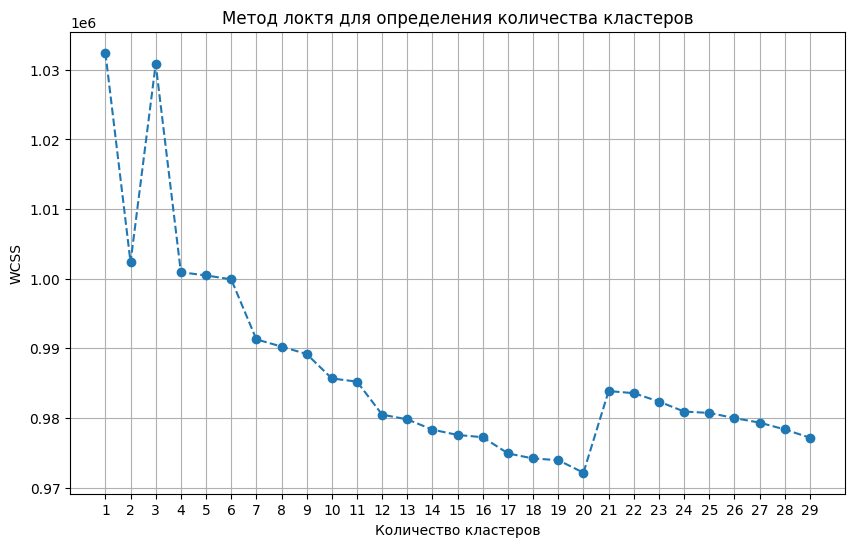

In [88]:
wcss = []
for i in range(1, 30):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(user_item_matrix_filled)
    wcss.append(kmeans.inertia_)

# Построим график метода локтя
plt.figure(figsize=(10, 6))
plt.plot(range(1, 30), wcss, marker='o', linestyle='--')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.title('Метод локтя для определения количества кластеров')
plt.xticks(range(1, 30))
plt.grid(True)
plt.show()


In [89]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
user_clusters = kmeans.fit_predict(user_item_matrix_filled)
user_clusters_df = pd.DataFrame(user_clusters, index=user_item_matrix.index, columns=['cluster'])

# Функция для рекомендаций на основе кластеров
def recommend_items_cluster(user_id, num_recommendations=5):
    user_cluster = user_clusters_df.loc[user_id, 'cluster']
    cluster_users = user_item_matrix_filled[user_clusters_df['cluster'] == user_cluster]
    
    # Средние рейтинги по каждому фильму для пользователей в кластере
    cluster_mean_ratings = cluster_users.mean()
    
    # Фильмы, которые пользователь уже оценил
    user_rated_items = user_item_matrix.loc[user_id].dropna().index
    
    recommendations = cluster_mean_ratings.drop(user_rated_items).nlargest(num_recommendations)
    
    return recommendations

print(recommend_items_cluster(user_id=1))

item_id
2858    0.281470
318     0.233087
1198    0.225542
858     0.207185
2571    0.200698
dtype: float64


Матричная факторизация (SVD)

In [90]:

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'item_id', 'rating']], reader)

svd = SVD(n_factors=50, reg_all=0.1, lr_all=0.005, n_epochs=20)

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)


Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8975  0.8975  0.8961  0.8998  0.8975  0.8977  0.0012  
MAE (testset)     0.7119  0.7122  0.7109  0.7145  0.7126  0.7124  0.0012  
Fit time          4.27    4.70    4.75    4.68    4.78    4.64    0.18    
Test time         0.83    0.67    0.81    0.84    0.87    0.80    0.07    


{'test_rmse': array([0.89750022, 0.89747925, 0.89614086, 0.89982573, 0.89745501]),
 'test_mae': array([0.71187546, 0.7121747 , 0.71093887, 0.71449566, 0.71260648]),
 'fit_time': (4.273454189300537,
  4.703697919845581,
  4.748880386352539,
  4.678105592727661,
  4.77515721321106),
 'test_time': (0.8272075653076172,
  0.6709787845611572,
  0.8082523345947266,
  0.8359870910644531,
  0.870988130569458)}

In [ ]:



param_grid = {'n_factors': [10, 20, 50, 100], 
              'reg_all': [0.01, 0.1, 0.5],
              'lr_all': [0.001, 0.005, 0.01],
              'n_epochs': [5]}
grid_search = GridSearchCV(SVD, param_grid, measures=['RMSE', 'MAE'], cv=5)
grid_search.fit(data)
print(grid_search.best_params)


{'rmse': {'n_factors': 100, 'reg_all': 0.01, 'lr_all': 0.01, 'n_epochs': 5}, 'mae': {'n_factors': 100, 'reg_all': 0.01, 'lr_all': 0.01, 'n_epochs': 5}}


In [93]:
best_params = grid_search.best_params['rmse']

svd = SVD(n_factors=best_params['n_factors'], 
               reg_all=best_params['reg_all'], 
               lr_all=best_params['lr_all'], 
               n_epochs=best_params['n_epochs'])

svd.fit(data.build_full_trainset())
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8929  0.8924  0.8939  0.8886  0.8907  0.8917  0.0019  
MAE (testset)     0.7045  0.7052  0.7061  0.7017  0.7035  0.7042  0.0015  
Fit time          1.66    1.84    1.64    1.68    1.49    1.66    0.11    
Test time         0.92    0.93    0.79    0.84    0.85    0.86    0.05    


{'test_rmse': array([0.89289059, 0.89244093, 0.8938944 , 0.88855875, 0.8906576 ]),
 'test_mae': array([0.70454085, 0.70523315, 0.70613556, 0.701713  , 0.70349671]),
 'fit_time': (1.6575944423675537,
  1.836195945739746,
  1.6360907554626465,
  1.6769344806671143,
  1.4898946285247803),
 'test_time': (0.9159016609191895,
  0.9338250160217285,
  0.7859950065612793,
  0.8392422199249268,
  0.8468732833862305)}

In [94]:
def recommend_items_svd(user_id, num_recommendations=5):
    user_rated_items = df[df['user_id'] == user_id]['item_id'].tolist()
    all_items = df['item_id'].unique()
    items_to_predict = list(set(all_items) - set(user_rated_items))
    
    predictions = [svd.predict(user_id, item_id) for item_id in items_to_predict]
    predictions.sort(key=lambda x: x.est, reverse=True)
    return [pred.iid for pred in predictions[:num_recommendations]]

print(recommend_items_svd(user_id=1))

[318, 3030, 920, 1198, 50]


Для сравнения методов используем корреляцию Пирсона.

In [95]:

item_based_recs = recommend_items_item_based(user_id=1)
user_based_recs = recommend_items_user_based(user_id=1)
cluster_recs = recommend_items_cluster(user_id=1)
svd_recs = recommend_items_svd(user_id=1)

svd_recs = pd.Series(svd_recs)

item_based_ratings = item_based_recs.values
user_based_ratings = user_based_recs.values
cluster_ratings = cluster_recs.values
svd_ratings = svd_recs.values
print("Item-based vs User-based:", pearsonr(item_based_ratings, user_based_ratings))
print("Item-based vs Cluster-based:", pearsonr(item_based_ratings, cluster_ratings))
print("Item-based vs SVD:", pearsonr(item_based_ratings, svd_ratings))
print("User-based vs Cluster-based:", pearsonr(user_based_ratings, cluster_ratings))
print("User-based vs SVD:", pearsonr(user_based_ratings, svd_ratings))
print("Cluster-based vs SVD:", pearsonr(cluster_ratings, svd_ratings))


Item-based vs User-based: PearsonRResult(statistic=0.7552990248692961, pvalue=0.13985131882879392)
Item-based vs Cluster-based: PearsonRResult(statistic=0.9299492380167805, pvalue=0.02202096585429068)
Item-based vs SVD: PearsonRResult(statistic=0.2812311492329294, pvalue=0.6467030999001758)
User-based vs Cluster-based: PearsonRResult(statistic=0.6811792646288075, pvalue=0.20545085313088066)
User-based vs SVD: PearsonRResult(statistic=0.48365431823478977, pvalue=0.4091227001050227)
Cluster-based vs SVD: PearsonRResult(statistic=-0.033209402430287485, pvalue=0.9577242490206898)


In [100]:
def get_movie_titles(item_ids, movies_df):
    return movies_df[movies_df['item_id'].isin(item_ids)]['title'].tolist()

user_ids = df['user_id'].unique()
user_ids = user_ids[:3]
item_based_recs_all = {}
user_based_recs_all = {}
cluster_recs_all = {}
svd_recs_all = {}

for user_id in user_ids:
    item_based_recs_all[user_id] = recommend_items_item_based(user_id)
    user_based_recs_all[user_id] = recommend_items_user_based(user_id)
    cluster_recs_all[user_id] = recommend_items_cluster(user_id)
    svd_recs_all[user_id] = recommend_items_svd(user_id)
    
    print(f"Recommendations for user {user_id}:")
    
    print("Item-based recommendations:")
    print(get_movie_titles(item_based_recs_all[user_id].index, movies_df))
    
    print("User-based recommendations:")
    print(get_movie_titles(user_based_recs_all[user_id].index, movies_df))
    
    print("Cluster-based recommendations:")
    print(get_movie_titles(cluster_recs_all[user_id].index, movies_df))
    
    print("SVD recommendations:")
    print(get_movie_titles(svd_recs_all[user_id], movies_df))
    
    print("\n")


Recommendations for user 1:
Item-based recommendations:
['Shawshank Redemption, The (1994)', 'Silence of the Lambs, The (1991)', "It's a Wonderful Life (1946)", 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Raiders of the Lost Ark (1981)']
User-based recommendations:
['Lion King, The (1994)', 'Jurassic Park (1993)', 'Godfather, The (1972)', 'Casablanca (1942)', 'African Queen, The (1951)']
Cluster-based recommendations:
['Shawshank Redemption, The (1994)', 'Godfather, The (1972)', 'Raiders of the Lost Ark (1981)', 'Matrix, The (1999)', 'American Beauty (1999)']
SVD recommendations:
['Usual Suspects, The (1995)', 'Shawshank Redemption, The (1994)', 'Gone with the Wind (1939)', 'Raiders of the Lost Ark (1981)', 'Yojimbo (1961)']


Recommendations for user 2:
Item-based recommendations:
['Star Wars: Episode IV - A New Hope (1977)', "Schindler's List (1993)", 'Godfather, The (1972)', 'Die Hard (1988)', 'Sixth Sense, The (1999)']
User-based recommendations:
['Star Wars: Episode 

In [175]:
from sklearn.model_selection import train_test_split

def split_data(df, test_size=0.2):
    train_data = []
    test_data = []

    for user_id, group in df.groupby('user_id'):
        train, test = train_test_split(group, test_size=test_size, random_state=42)
        train_data.append(train)
        test_data.append(test)

    return pd.concat(train_data), pd.concat(test_data)

train_df, test_df = split_data(df)


In [ ]:
test_movies = set(test_df['item_id'])
train_movies = set(train_df['item_id'])

missing_movies = test_movies - train_movies
missing_data = df[df['item_id'].isin(missing_movies)]
train_df = pd.concat([train_df, missing_data])


if missing_movies:
    print(f"Missing movies in train set: {missing_movies}")
else:
    print("All movies from the test set are in the training set.")
missing_movies = test_movies - train_movies


All movies from the test set are in the training set.


In [179]:
def evaluate_recommendation_method(method_func, test_df, user_id, num_recommendations=5):
    rmse_list = []
    ground_truth = test_df[test_df['user_id'] == user_id].set_index('item_id')['rating']

    try:
        recommendations = method_func(user_id, num_recommendations)
        if isinstance(recommendations, pd.Series):
            predictions = recommendations
        else:
            predictions = pd.Series(recommendations, index=recommendations)
    except KeyError:
        return {'RMSE': None}

    rmse = calculate_rmse(predictions, ground_truth)
    if rmse is not None:
        rmse_list.append(rmse)

    avg_rmse = np.mean(rmse_list) if rmse_list else None

    return {'RMSE': avg_rmse}


In [189]:
def evaluate_rmse_for_user(user_id, train_df, test_df, recommend_method, num_recommendations=5):
    ground_truth = test_df[test_df['user_id'] == user_id].set_index('item_id')['rating']
    recommendations = recommend_method(user_id, train_df, test_df, num_recommendations)
    common_items = ground_truth.index.intersection(recommendations.index)
    
    if len(common_items) == 0:
        return None
    y_true = ground_truth[common_items]
    y_pred = recommendations[common_items]
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    return rmse


In [207]:
def recommend_items_item_based(user_id, train_df, test_df, num_recommendations=5):
    user_ratings = train_df[train_df['user_id'] == user_id].set_index('item_id')['rating'].dropna()
    scores = pd.Series(0, index=item_similarity_df.columns)
    
    for item, rating in user_ratings.items():
        scores += item_similarity_df[item] * rating
    
    scores = scores.drop(user_ratings.index)

    user_test_items = test_df[test_df['user_id'] == user_id]['item_id']
    scores = scores.loc[scores.index.isin(user_test_items)]
    
    return scores.nlargest(num_recommendations)


def recommend_items_user_based(user_id, train_df, test_df, num_recommendations=5):
    user_similarity = cosine_similarity(user_item_matrix_filled)
    user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)
    
    similar_users = user_similarity_df[user_id].drop(user_id).nlargest(5)
    
    weighted_ratings = pd.Series(0, index=user_item_matrix.columns)
    
    for similar_user, similarity in similar_users.items():
        user_ratings = user_item_matrix.loc[similar_user].dropna() 
        weighted_ratings.loc[user_ratings.index] += user_ratings * similarity 
    
    weighted_ratings = weighted_ratings.drop(user_item_matrix.loc[user_id].dropna().index)

    user_test_items = test_df[test_df['user_id'] == user_id]['item_id']
    weighted_ratings = weighted_ratings.loc[weighted_ratings.index.isin(user_test_items)]
    
    return weighted_ratings.nlargest(num_recommendations)


def recommend_items_cluster_based(user_id, train_df, test_df, num_recommendations=5):
    kmeans = KMeans(n_clusters=4, random_state=42)
    user_clusters = kmeans.fit_predict(user_item_matrix_filled)
    
    user_cluster = user_clusters[train_df[train_df['user_id'] == user_id].iloc[0]['user_id']]
    
    similar_users_in_cluster = train_df[train_df['user_id'].isin(user_item_matrix_filled.index[user_clusters == user_cluster])]

    weighted_ratings = pd.Series(0, index=user_item_matrix.columns)
    
    for _, similar_user in similar_users_in_cluster.iterrows():
        user_ratings = user_item_matrix.loc[similar_user['user_id']].dropna()
        weighted_ratings.loc[user_ratings.index] += user_ratings
    
    user_ratings = user_item_matrix.loc[user_id].dropna()
    weighted_ratings = weighted_ratings.drop(user_ratings.index)

    user_test_items = test_df[test_df['user_id'] == user_id]['item_id']
    weighted_ratings = weighted_ratings.loc[weighted_ratings.index.isin(user_test_items)]

    return weighted_ratings.nlargest(num_recommendations)



In [193]:
user_id = 1
item_based_metrics = evaluate_rmse_for_user(user_id, train_df, test_df, recommend_items_item_based)
print(f"Item-based RMSE for user {user_id}: {item_based_metrics}")


Item-based RMSE for user 1: 15.053164526459291


In [200]:
user_based_rmse = evaluate_rmse_for_user(user_id, train_df, test_df, recommend_items_user_based)
print(f"User-based RMSE for user {user_id}: {user_based_rmse}")


User-based RMSE for user 1: 3.2380474310782628


In [208]:
cluster_based_rmse = evaluate_rmse_for_user(user_id, train_df, test_df, recommend_items_cluster_based)
print(f"Cluster-based RMSE for user {user_id}: {cluster_based_rmse}")


Cluster-based RMSE for user 1: None
